# 简介

自研单阶段无锚框目标检查算法SSYOLOv1，在[路标检测数据集](https://aistudio.baidu.com/aistudio/datasetdetail/85408)上的精度可到到94.63%，模型参数量为3.2M。骨干网络使用自研的SSRNetv3，在骨干网络中将特征提取与特征融合进行合并，简化了FPN结构。检测头部使用YOLOX的解耦头部。在计算损失函数时，使用YOLOX的是SimOTA标签分配策略。详细算法说明会在后续进行，欢迎关注并提供改进建议。[[运行一下](https://aistudio.baidu.com/aistudio/projectdetail/3243946)]

# 数据处理

## 解压数据文件

In [ ]:
# !unzip -oq -d data/ data/roadsign_voc.zip

## 创建数据列表

In [ ]:
# !python data/create_list.py images annotations .png 0.8

## 绘制目标边框

In [ ]:
# !python data/draw_bndbox.py valid.txt label.txt

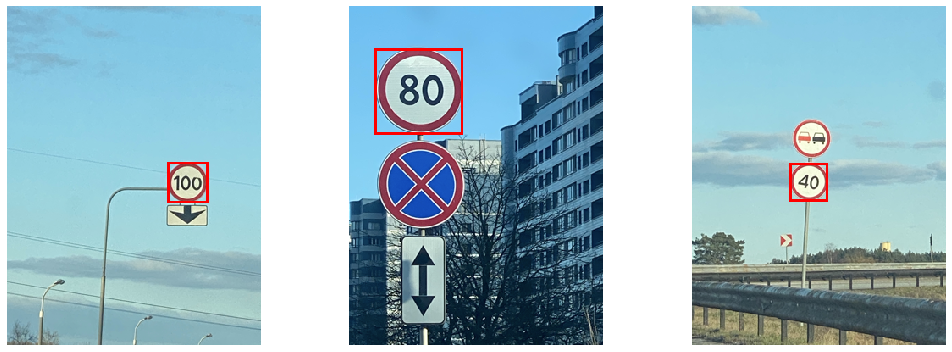

In [2]:
import os, sys
import matplotlib.pyplot as plt
import numpy as np
import xml.etree.ElementTree as et
from PIL import Image, ImageDraw

class BndBox():
    def __init__(self, lists_txt, label_txt):
        """
        初始化目标边框
        params:
        - lists_txt: 列表文件
        - label_txt: 标签文件
        - lists_dir: 列表目录
        """
        self.lists_txt = lists_txt
        self.label_txt = label_txt
        self.lists_dir = os.path.split(lists_txt)[0]                            # 列表目录
        self.cname2cid = self.get_cname2cid()                                   # 标签字典
        self.cls_color = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)] # 类别颜色
    
    def draw(self):
        """
        绘制目标边界框
        """
        # 创建画布
        plt.figure(figsize=(15, 5))
        
        # 绘制边框
        with open(self.lists_txt, 'r') as f:
            for i, line in enumerate(f.readlines()):
                # 读取标注
                if i > 2: # 读取三张图片
                    break
                image_path, annotation_path = line.strip().split()                   # 提取信息
                image = Image.open(os.path.join(self.lists_dir, image_path))         # 打开图像
                annotation = et.parse(os.path.join(self.lists_dir, annotation_path)) # 打开标注
                
                # 绘制边框
                draw = ImageDraw.Draw(image)                               # 创建画笔
                
                img_w = float(annotation.find('size').find('width').text)  # 图像宽度
                img_h = float(annotation.find('size').find('height').text) # 图像高度
                
                object_list = annotation.findall('object')                 # 目标列表
                gtcls = np.zeros((len(object_list),  ), dtype='float32')   # 目标类别
                gtbox = np.zeros((len(object_list), 4), dtype='float32')   # 目标边框
                
                for object_id, object_item in enumerate(object_list):
                    # 获取目标类别
                    cname = object_item.find('name').text    # 类别名称
                    gtcls[object_id] = self.cname2cid[cname] # 类别编号

                    # 获取目标边框
                    x1 = float(object_item.find('bndbox').find('xmin').text)
                    y1 = float(object_item.find('bndbox').find('ymin').text)
                    x2 = float(object_item.find('bndbox').find('xmax').text)
                    y2 = float(object_item.find('bndbox').find('ymax').text)
                    
                    x1 = max(0, x1)
                    y1 = max(0, y1)
                    x2 = min(x2, img_w - 1)
                    y2 = min(y2, img_h - 1)
                    
                    gtbox[object_id] = [x1, y1, x2, y2]
                    
                    # 绘制边框
                    draw.rectangle(xy=gtbox[object_id],outline=self.cls_color[int(gtcls[object_id])],width=3)

                # 绘制图像
                image = np.array(image, dtype='uint8') # 转换格式
                plt.subplot(1, 3, i+1)                 # 设置图表
                plt.axis('off')                        # 关闭坐标
                plt.imshow(image)                      # 设置图片
        
        # 显示图像
        plt.tight_layout() # 设置布局
        plt.show()         # 显示图表
    
    def get_cname2cid(self):
        """
        获取标签字典
        return:
        - cname2cid: 标签字典
        """
        # 文件是否存在
        if not os.path.exists(self.label_txt):
            print(f'错误：{self.label_txt}不存在！')
            sys.exit()

        # 设置标签字典
        cname2cid = {} # 标签字典
        with open(label_txt, 'r') as f:
            for cid, cname in enumerate(f.readlines()):
                cname2cid[cname.strip()] = cid
    
        return cname2cid

# 绘制目标边框
lists_txt = './data/train.txt'        # 列表文件
label_txt = './data/label.txt'        # 标签文件

bndbox = BndBox(lists_txt, label_txt) # 创建边框
bndbox.draw()                         # 绘制边框

## 读取批次数据

train_dataset - image:[3, 320, 320, 3], gtcls:[3, 50], gtbox:[3, 50, 4], imghw:[3, 2]


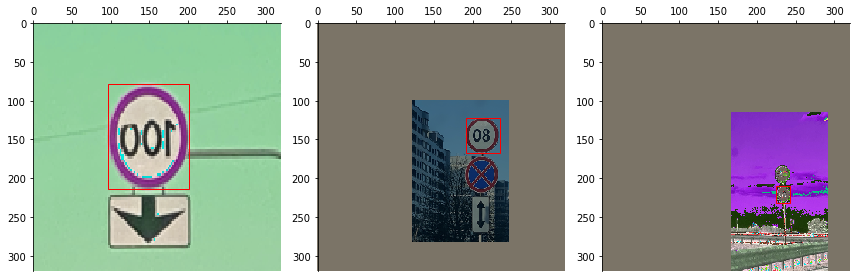

In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import paddle
from src.data import VOCDataset, Compose, RandomDistort, RandomExpand, RandomCrop, RandomFlip, BatchCompose, RandomResize, PadClassBox

# 读取数据
train_txt = './data/train.txt' # 训练文件
label_txt = './data/label.txt' # 标签文件
batch_size = 3                 # 批样本数
worker_num = 0                 # 子进程数

transforms = Compose([
    RandomDistort(),                                         # 随机变换图像
    RandomExpand(fill_value=(123.675, 116.28, 103.53)),      # 随机扩大图像
    RandomCrop(),                                            # 随机裁剪图像
    RandomFlip()                                             # 随机水平翻转
])                                                           # 数据增强方法
train_dataset = VOCDataset(train_txt, label_txt, transforms) # 训练集迭代器
batch_sampler = paddle.io.DistributedBatchSampler(           # 批次数据采样
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False
)
batch_transforms = BatchCompose([                                           # 批次数据增强
    RandomResize(dsize=[320, 352, 384, 416, 448, 480, 512, 544, 576, 608]), # 随机缩放图像
    PadClassBox(num_max=50)                                                 # 填充类别边框
])
train_loader = paddle.io.DataLoader(                                        # 训练集迭代器
    dataset=train_dataset,
    batch_sampler=batch_sampler,
    collate_fn=batch_transforms,
    num_workers=worker_num,
    return_list=False,
    use_buffer_reader=True,
    use_shared_memory=False
)

# 显示图像
for i, data in enumerate(train_loader()):
    # 创建画布
    print(f'train_dataset - image:{data[0].shape}, gtcls:{data[1].shape}, gtbox:{data[2].shape}, imghw:{data[3].shape}')
    plt.figure(figsize=(12, 4))
    
    # 绘制边框
    for j in range(batch_size):
        # 读取图像边框
        image = data[0].numpy()[j] # 读取图像
        gtbox = data[2].numpy()[j] # 读取边框

        # 设置子图坐标
        ax = plt.subplot(1, 3, j+1)                 # 获取子图坐标轴
        ax.xaxis.set_ticks_position('top')          # 设置上轴为x轴
        ax.spines['top'].set_position(('data', 0))  # 轴刻度从零开始
        ax.yaxis.set_ticks_position('left')         # 设置左轴为y轴
        ax.spines['left'].set_position(('data', 0)) # 轴刻度从零开始
        ax.spines['bottom'].set_color('none')       # 关闭下面坐标轴
        ax.spines['right'].set_color('none')        # 关闭右边坐标轴
        
        # 绘制图像边框
        for k in range(len(gtbox)): # 遍历边框
            if (gtbox[k, 2] - gtbox[k, 0]) > 1e-6 and (gtbox[k, 3] - gtbox[k, 1]) > 1e-6:
                # 获取边框坐标
                x = gtbox[k, 0]
                y = gtbox[k, 1]
                w = gtbox[k, 2] - gtbox[k, 0]
                h = gtbox[k, 3] - gtbox[k, 1]

                # 绘制目标边框
                rectangle = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', fill=False) # 设置边框
                ax.add_patch(rectangle)                                                             # 绘制边框
        
        # 填充子图图像
        ax.imshow(image)

    # 显示图像
    plt.tight_layout() # 设置布局
    plt.show()         # 显示图表
    break

In [4]:
from src.data import DataLoader

# 读取数据文件
train_txt = './data/train.txt' # 训练文件
valid_txt = './data/valid.txt' # 验证文件
label_txt = './data/label.txt' # 标签文件

# 读取训练数据
train_loader = DataLoader(train_txt, label_txt, batch_size=8, worker_num=0, mode='train')
for i, data in enumerate(train_loader):
    print(f"train_dataset - image:{data['image'].shape}, gtcls:{data['gtcls'].shape}, gtbox:{data['gtbox'].shape}, imghw:{data['imghw'].shape}")
    break

# 读取验证数据
valid_loader = DataLoader(valid_txt, label_txt, batch_size=8, worker_num=0, mode='valid')
for i, data in enumerate(valid_loader):
    print(f"valid_dataset - image:{data['image'].shape}, gtcls:{data['gtcls'].shape}, gtbox:{data['gtbox'].shape}, imghw:{data['imghw'].shape}")
    break

train_dataset - image:[8, 3, 352, 352], gtcls:[8, 50], gtbox:[8, 50, 4], imghw:[8, 2]
valid_dataset - image:[8, 3, 608, 608], gtcls:[8, 50], gtbox:[8, 50, 4], imghw:[8, 2]


# 模型组网

## 骨干网络

In [1]:
import paddle
from src.model.ssrnet import SSRNet

# 骨干网络
backbone = SSRNet(group_arch=[[3, 64, 256, 3, 8, 2], [128, 64, 256, 1, 4, 2], [128, 64, 256, 1, 2, 2]], block_mode='ssr')

# 输入数据
x = paddle.randn([1, 3, 608, 608], dtype='float32')

# 前向传播
c_list = backbone(x)

# 输出特征
print(f'骨干网络: c4: {c_list[0].shape}, c3: {c_list[1].shape}, c2: {c_list[2].shape}')

骨干网络: c4: [1, 256, 19, 19], c3: [1, 256, 38, 38], c2: [1, 256, 76, 76]


## 检测头部

In [2]:
import paddle
from src.model.sshead import SSHead

# 检测头部
det_head = SSHead(num_classes=4, in_channels=[256, 256, 256])

# 输入数据
c2 = paddle.randn([1, 256, 19, 19], dtype='float32')
c3 = paddle.randn([1, 256, 38, 38], dtype='float32')
c4 = paddle.randn([1, 256, 76, 76], dtype='float32')
c_list = [c2, c3, c4]

# 前向传播
p_list = det_head(c_list)

# 输出特征
print(f'检测头部: p4: {p_list[0].shape}  , p3: {p_list[1].shape}  , p2: {p_list[2].shape}')

检测头部: p4: [1, 9, 19, 19]  , p3: [1, 9, 38, 38]  , p2: [1, 9, 76, 76]


## 计算损失

In [5]:
import paddle
from src.data import DataLoader
from src.model.ssyolo import SSYOLO

# 训练数据
train_txt = './data/valid.txt'                                                            # 训练文件
label_txt = './data/label.txt'                                                            # 标签文件
train_loader = DataLoader(train_txt, label_txt, batch_size=1, worker_num=0, mode='valid') # 训练数据

# 定义网络
model = SSYOLO(num_classes=4)                                                             # 检测网络
model.train()                                                                             # 训练模式

# 网络参数
# params = paddle.summary(model, (1, 3, 608, 608))
# print('网络参数：', params)

# 处理数据
for inputs in train_loader:
    # 读取图像
    images = inputs['image']
    
    # 前向传播
    p_list = model(images)
    
    # 计算损失
    losses = model.get_loss(p_list, inputs)
    break

# 显示结果
print(f'网络损失: losses: {losses.numpy()}')

网络损失: losses: [6779.5034]


## 计算预测

In [6]:
import os, paddle
from src.data import DataLoader
from src.model.ssyolo import SSYOLO

# 验证数据
valid_txt = './data/valid.txt'                                                            # 验证文件
label_txt = './data/label.txt'                                                            # 标签文件
valid_loader = DataLoader(valid_txt, label_txt, batch_size=1, worker_num=0, mode='valid') # 验证数据

# 定义网络
model = SSYOLO(num_classes=4) # 检测网络
model.eval()                  # 验证模式

# 加载权重
save_path = './out/'                                                      # 权重路径
model_state_dict = paddle.load(os.path.join(save_path, 'great.pdparams')) # 加载权重
model.set_state_dict(model_state_dict)                                    # 设置权重

# 处理数据
for inputs in valid_loader:
    # 读取数据
    images = inputs['image'] # 图像数据
    imghws = inputs['imghw'] # 图像高宽
    
    # 前向传播
    p_list = model(images)
    
    # 计算预测
    infers = model.get_pred(p_list, imghws)
    break
    
# 显示结果
for infer in infers: # 遍历批次
    print(f'网络预测: number: {len(infer)}') # 打印每批预测物体数量

网络预测: number: 2


# 模型训练

In [ ]:
from src.train import Trainer

# 实例化训练器
trainer = Trainer(
    train_batch=16,                       # 训练批次大小
    valid_batch=8,                        # 验证批次大小
    epoch_num  =600,                      # 训练轮次总数
    eval_save  =5,                        # 验证保存频率，每隔多少轮验证并保存一次
    iter_show  =3,                        # 迭代显示次数，每个轮次中迭代显示的次数
    lin_epoch  =10,                       # 线性预热轮数
    lrate_max  =0.01,                     # 最大学习率值
    cos_value  =0.0,                      # 余弦止学习率，当分段衰减为空时使用余弦
    pie_epoch  =None,                     # 分段衰减轮数
    pie_value  =None,                     # 分段学习率值
    optimizer  ='AdamW',                  # 权重值优化器，必须为Momentum或AdamW
    l2_decays  =0.001,                    # 权重衰减系数
    num_classes=4,                        # 物体类别数量
    bbox_thresh=0.50,                     # 验证边框阈值
    load_flag  ='none',                   # 加载断点标识，none,resume,finetune
    train_txt  ='./data/train.txt',       # 训练数据路径
    valid_txt  ='./data/valid.txt',       # 验证数据路径
    label_txt  ='./data/label.txt',       # 标签文件路径
    save_path  ='./out/',                 # 模型保存路径
    logs_path  ='./log/'                  # 日志保存路径
)

# 启动训练数据
trainer.train()

# 模型预测

infer time: 58.594 ms


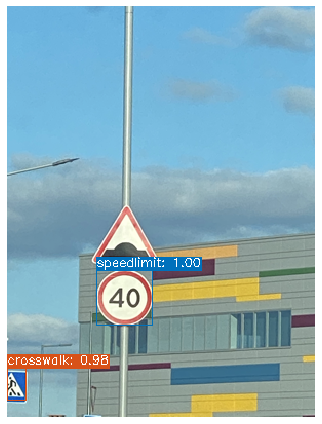

In [9]:
from src.infer import Inferer

# 实例化推理器
inferer = Inferer(
    num_classes=4,                      # 物体类别数量
    model_param='./out/great.pdparams', # 模型参数路径
    label_path ='./data/label.txt',     # 物体标签路径
    output_dir ='./out/',               # 输出结果目录
    scale_size =608,                    # 图像缩放大小
    bbox_thick =1,                      # 物体边框粗细
    font_thick =1,                      # 文本边框粗细
    font_scale =0.4                     # 文本字体大小
)

# 启动推理图像
inferer.infer(image_path='./data/images/road554.png')